# Machine learning Based Type Well Selection and Its Application

* __Author__: Wen Pan, Tianqi Deng
* __Date__: Feb 1st, 2022

- <a>1. Introduction </a>
    - <a>1.1. Summary and Disclaimer</a>
    - <a>1.2. Problem Statement</a>
    - <a>1.3. Data Description</a>
    - <a>1.4. Evaluation Metric</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Glimpse of Data</a>
- <a>5. Exploratory Data Analysis</a>
- <a>6. Type Well Selection and Model Building</a>
- <a>7. Discussion</a>

<a></a>

## Summary

In this notebook, we mainly demonstrate methods for statistics/ML based type well selection and how to integrate these methods with simple machine learning models to perform well-log interpretation. Please refer to **"Reducing the Uncertainty of Multi-Well Petrophysical Interpretation from Well Logs with Statistical and Machine Learning Models" by Pan et al, submitted, 2022.**, **"Feature Engineering in Well-Log Interpretation" presented by Pan et al. at GEOGULF 2021** and **"Well-Log Normalization and Well-to-Well Correlation via Machine Learning Methods" presented by Pan et al. at 2021 UT DIRECT and Formation Evaluation Consortium** for more details about assumptions and more advanced workflows.

We did some DOE to find the optimal choice of methods, below are our findings based on our multiple submissions:

- We find by incorporating well adaption proposed by Pan et al. (2022), we successfully reduce the uncertainty associated with multi-well well-log interpretation. 

- The adaption method was proven to be useful in well-log interpretation for clean carbonate reservoir, and in this conpetition we demonstrate that this method can also be used for shaly reservoir.

- Compared to last year, this year we performed automatic well correlation instead of mannual correlation to help identify type well, greatly reducing the time for preprocessing.

- The application of well adaption mitigates errors and non-uniqueness introduced by different borehole environments and allow more robust interpretation as discussed in Pan et al(2022).

- semisupervised learning integrated with spatial continuity help mitigate the error introduced by imputing data with bad coverage.

- Since we mostly use the simplist ML model in this workflow, only a few hyperparameters are tuned.

- We strongly recommend interested readers to read "Reducing the Uncertainty of Multi-Well Petrophysical Interpretation from Well Logs with Statistical and Machine Learning Models" to better understand the assumptions and reasoning of this method, and how this method can be incorporated with other constraints and machine learning models to help improve well-log interpretation accuracy. 





Please cite following publications if you are using this workflow for academic study.
- "Reducing the Uncertainty of Multi-Well Petrophysical Interpretation from Well Logs with Statistical and Machine Learning Models", Pan et al.(2022)
- "Feature Engineering in Well-Log Interpretation" presented by Pan et al. at GEOGULF 2021 
- T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
- J. Stat. Soft., doi:10.18637/jss.v031.i07
- Pérez-Cruz, F. Kullback-Leibler divergence estimation ofcontinuous distributions IEEE International Symposium on Information Theory, 2008.

### <a>1.2. Problem Statement</a>
The objective of this contest is to develop data-driven models to estimate reservoir properties, including shale volume, porosity, and fluid saturation, based on a common set of well logs, including gamma ray, bulk density, neutron porosity, resistivity, and sonic. The participants will be provided with log data from eight wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. They need to build a data-driven model using the provided training data set. Following that, they will deploy the newly developed data-driven models on the test data set to predict the reservoir properties based on
the well-log data.

You will be provided with log data from about 10 wells from the same field together with the corresponding reservoir properties estimated by petrophysicists. You need to build a data-driven model using the provided training dataset. Following that, you will deploy the newly developed data-driven models on the test dataset to predict the reservoir properties based on the well log data. 

### <a>1.3. Data Description</a>
#### Files
&gt; #### train.csv
(All the values equals to -9999 are marked as missing values.)
- WELLNUM - Well number
- DEPTH - Depth, unit in feet
- DTC - Compressional Travel-time, unit in nanosecond per foot
- DTS - Shear Travel-time, unit in microseconds per foot
- BS - Bit size, unit in inch
- CAL - Caliper, unit in Inc
- DEN - Density, unit in Gram per cubic centimeter 
- DENC - Corrected density, unit in Gram per cubic centimeter 
- GR - Gamma Ray, unit in API
- NEU - Neutron, unit in dec
- PEF - Photo-electric Factor, unit in barns/e
- RDEP - Deep Resistivity, unit in Ohm.m
- RMED - Medium Resistivity, unit in Ohm.m
- ROP - Rate of penetration, unit in meters per hour
- PHIF - Porosity, a unit equals to the percentage of pore space in a unit volume of rock.
- SW - Water saturation
- VSH - Shale Volume

&gt; #### test.csv
The test data has all features that you used in the train dataset, except PHIF, SW, and VSH.

&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
Submissions are evaluated according to root mean squared error(RMSE)

$$RMSE = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{\mathbf{y_{i}}} - \mathbf{y_{i}})^{2}} = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(\hat{y}_{1, i} - y_{1, i})^{2}+(\hat{y}_{2, i} - y_{2, i})^{2}+(\hat{y}_{3, i} - y_{3, i})^{2}}$$

where
- $\hat{y_i}$ is the predicted values of the true values $y_i$. Both $\hat{y_i}$ and $y_i$ are vectors with 3 elements: $y_{1,i}$ - PHIF, $y_{2,i}$ - SW, and $y_{3,i}$ - VSH. 
- $m$ is sample size.

**Note**:
- Please remember to use random_state for all randomization steps, so the results are reproducible. 
- PHIF, SW, and VSH are in the same weight during the evaluation. 
- Understanding and optimizing your predictions for this evaluation metric is paramount for this competition.

## <a>2. Imports</a>

In [47]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
from scipy.ndimage import median_filter
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import mode
from scipy.spatial import cKDTree as KDTree
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.spatial import KDTree
from dtw import *
from scipy.spatial.distance import jensenshannon
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsRegressor
np.random.seed(666)

## <a>3. Read Data</a>

In [48]:
df1 = pd.read_csv('train.csv')
col_names =  ['WELLNUM','DEN', 'GR', 'NEU'] + list(df1.columns.values[-3:])
col_names2 =  ['WELLNUM','DTC','DEN', 'GR', 'NEU','log_rd']

# Replace -9999 with np.nan
df1.replace(['-9999', -9999], np.nan, inplace=True)
df1['log_rd']=np.log(df1['RDEP'])

# per well property
wells=df1['WELLNUM'].unique()
per_well=[df1[df1['WELLNUM']==i].copy() for i in wells] 

## <a>4. Glimpse of Data</a>

In [49]:
# check well log size for potential imbalanced well data
log_size=[i.shape[0] for i in per_well]
print(log_size)

[29754, 34361, 34871, 32691, 38971, 35790, 45874, 43786, 22869]


In [50]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1.describe()

,WELLNUM,DEPTH,DTC,DTS,BS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,ROP,PHIF,SW,VSH,log_rd
count,318967.00,318967.00,69894.00,43848.00,287913.00,96157.00,95620.00,89116.00,315848.00,95439.00,88536.00,288519.00,288753.00,286588.00,47314.00,47314.00,45100.00,288519.00
mean,4.08,6998.18,77.16,140.49,16.86,8.70,2.45,0.05,55.29,0.17,5.76,5.14,158.10,28.55,0.14,0.70,0.31,0.36
std,2.46,3797.94,15.39,36.09,7.07,0.38,0.16,0.02,38.60,0.10,2.53,168.91,3082.52,18.16,0.09,0.35,0.25,0.98
min,0.00,335.16,1.03,74.82,8.50,6.00,1.63,-0.98,0.15,-0.00,-0.02,0.07,0.06,0.00,0.00,0.01,-0.25,-2.73
25%,2.00,3757.87,66.36,119.02,8.50,8.58,2.31,0.04,24.33,0.11,4.89,0.74,0.77,19.45,0.06,0.34,0.12,-0.30
50%,4.00,6905.18,72.40,130.53,17.50,8.62,2.51,0.05,55.98,0.16,6.14,1.21,1.26,25.92,0.13,0.93,0.25,0.19
75%,6.00,10052.49,85.58,144.34,26.00,8.69,2.58,0.06,79.24,0.22,7.74,2.18,2.35,32.22,0.22,1.00,0.39,0.78
max,8.00,15651.58,181.81,388.84,36.00,20.33,3.09,0.33,1124.44,1.46,13.84,80266.80,97543.40,208.63,0.40,1.00,3.65,11.29


In [51]:
# import test data and do simple imputation, iteration will be performed to imrpove the imputation results
df2 = pd.read_csv('test.csv')
df2.replace(['-9999', -9999], np.nan, inplace=True)

wells2=df2['WELLNUM'].unique()
per_well2=[df2[df2['WELLNUM']==i].copy() for i in wells2]   

# impute data with KNN
for i in per_well2:
    i['log_rd']=np.log(i['RDEP'])
    imp = KNNImputer(n_neighbors=1)
    i.loc[:,col_names2[1:]]=imp.fit_transform(i.loc[:,col_names2[1:]].values)
    i['RDEP']=np.exp(i['log_rd'])

## <a>5. EDA</a>

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, missing values, outliers, anomalies, patterns, or relationships within the data. 

- We examined summary statistics, pair-wise statistics and data coverage

In [52]:
df1.keys() # available logs

Index(['WELLNUM', 'DEPTH', 'DTC', 'DTS', 'BS', 'CALI', 'DEN', 'DENC', 'GR',
       'NEU', 'PEF', 'RDEP', 'RMED', 'ROP', 'PHIF', 'SW', 'VSH', 'log_rd'],
      dtype='object')

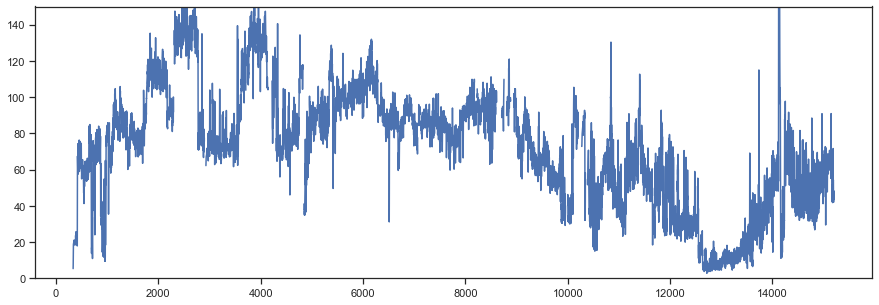

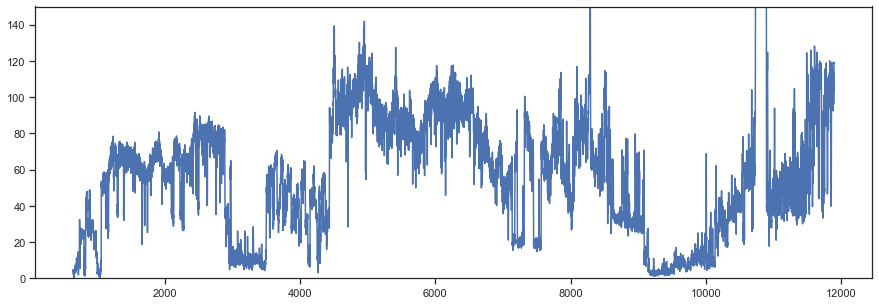

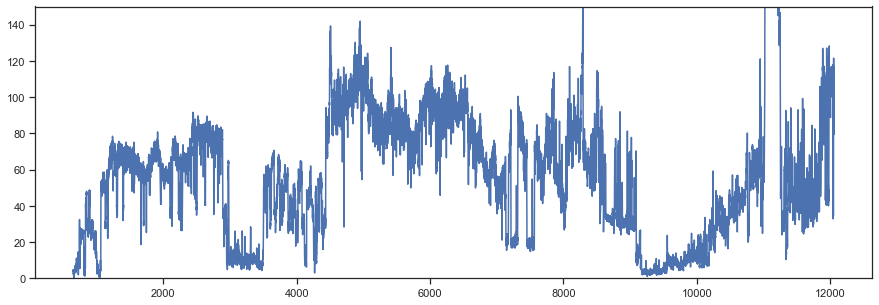

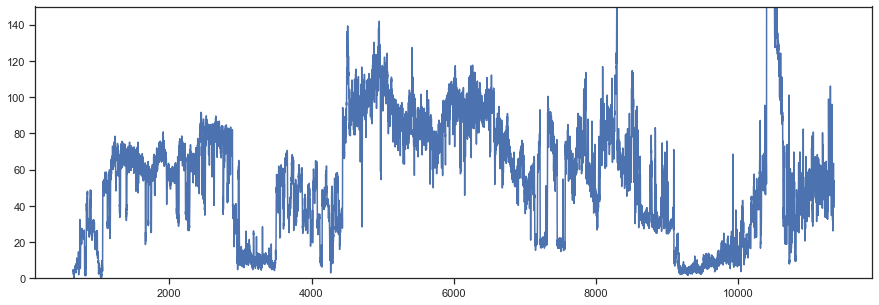

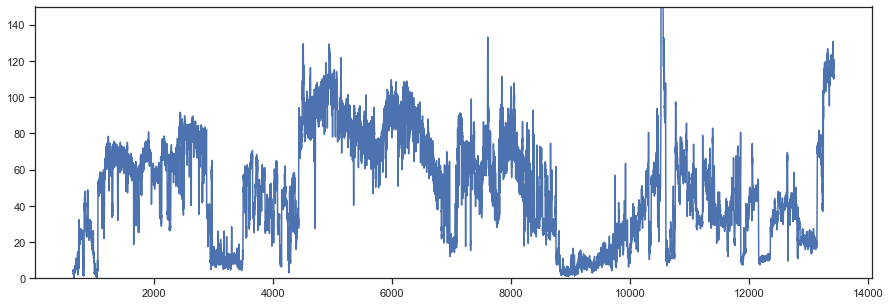

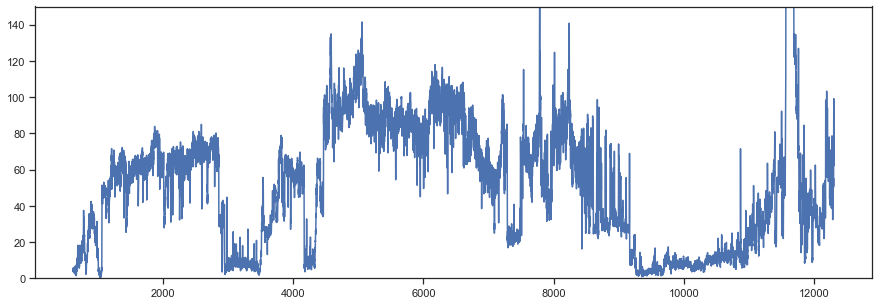

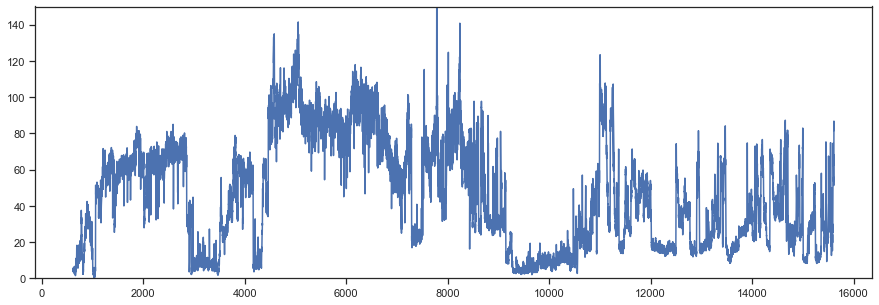

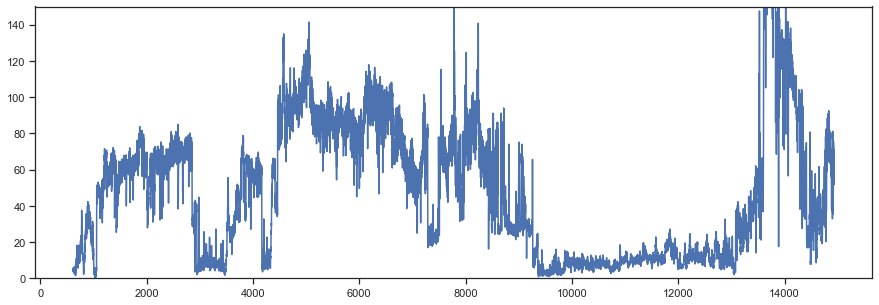

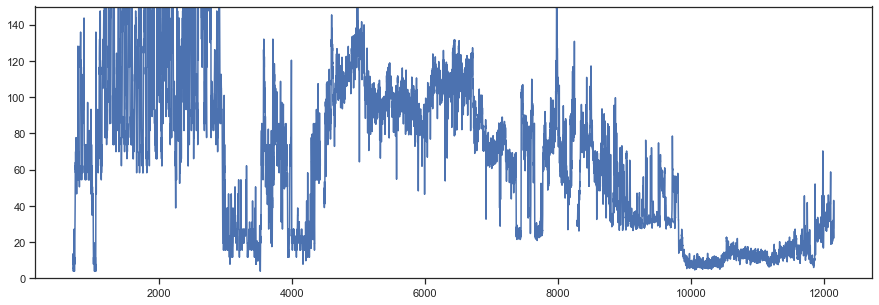

In [53]:
# visualize gamma ray of the training and test set, the training data has a larger coverage compared to test data.
for i in per_well:
    plt.figure(figsize=(15,5))
    plt.plot(i['DEPTH'],i['GR'])
    plt.ylim([0,150])

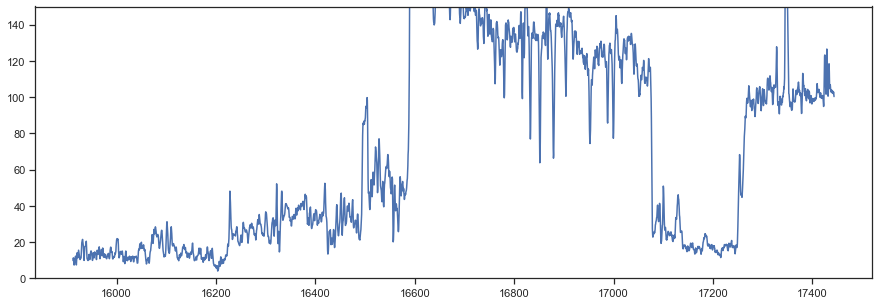

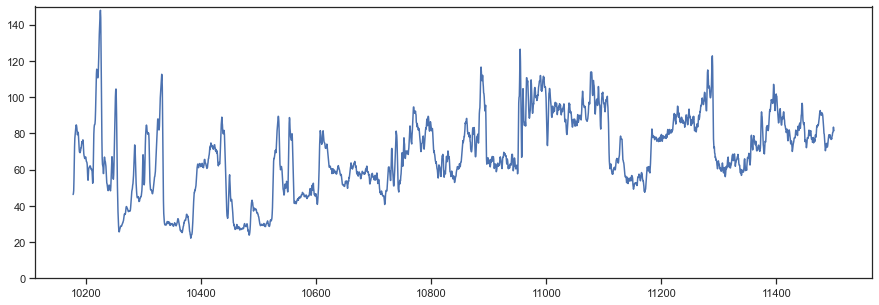

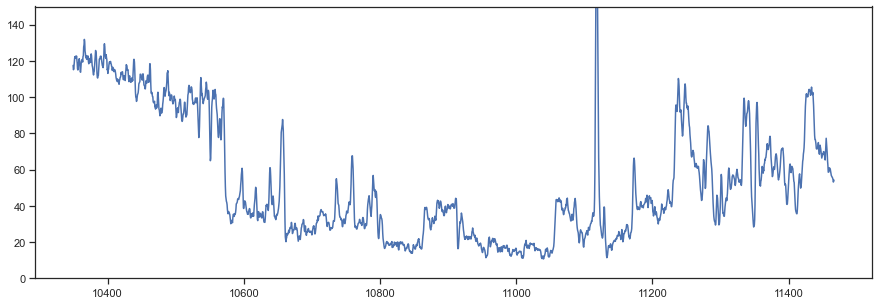

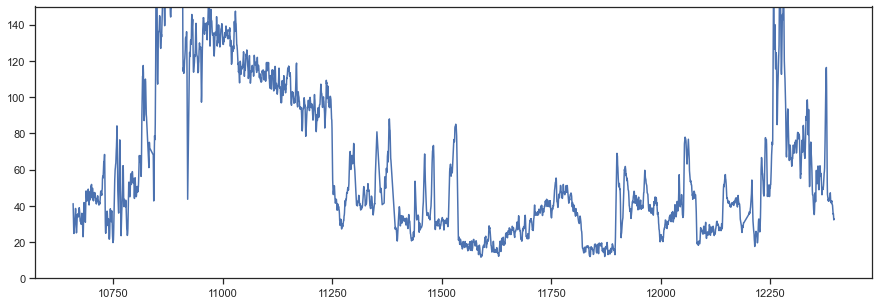

In [54]:
# visualize test data, smaller coverage of depth
for i in per_well2:
    plt.figure(figsize=(15,5))
    plt.plot(i['DEPTH'],i['GR'])
    plt.ylim([0,150])

## <a>6. Type Well Selection and Model Building</a>

### Correlation

From the scatter plot between VSH and GR we found a strong linear correlation, other features are excluded from VSH prediction to avoid collinearlity. However, the linear trend varies with well, therefore we decide to use methods proposed by Pan et al.(2021), to adapt test wells to training wells.

In [55]:
df1.keys()

Index(['WELLNUM', 'DEPTH', 'DTC', 'DTS', 'BS', 'CALI', 'DEN', 'DENC', 'GR',
       'NEU', 'PEF', 'RDEP', 'RMED', 'ROP', 'PHIF', 'SW', 'VSH', 'log_rd'],
      dtype='object')

<AxesSubplot:xlabel='GR', ylabel='VSH'>

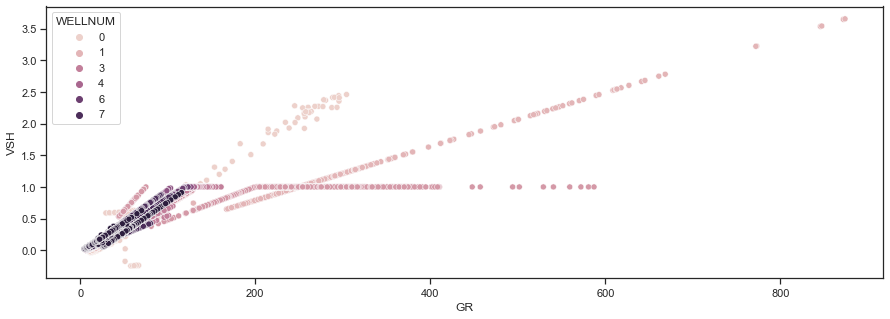

In [56]:
# Different linear correlation in different wells, we assume rock is a mixture of pure sand and pure shale, 
# and the GR of pure sand and shale can uniquely decide the model.
# VSH<0 and VSH>1 represent pure sand and shale respectively
plt.figure(figsize=(15,5))
sns.scatterplot(data=df1,x='GR',y='VSH',hue='WELLNUM')

In [57]:
# visualize training and test data converage in the feature space
for i in per_well:
    i['type']='train'
for i in per_well2:
    i['type']='test'
all_well=per_well+per_well2
all_dat=pd.concat(all_well,axis=0)
all_dat=all_dat.dropna(axis=0, subset=['GR','DEN','NEU','log_rd'])

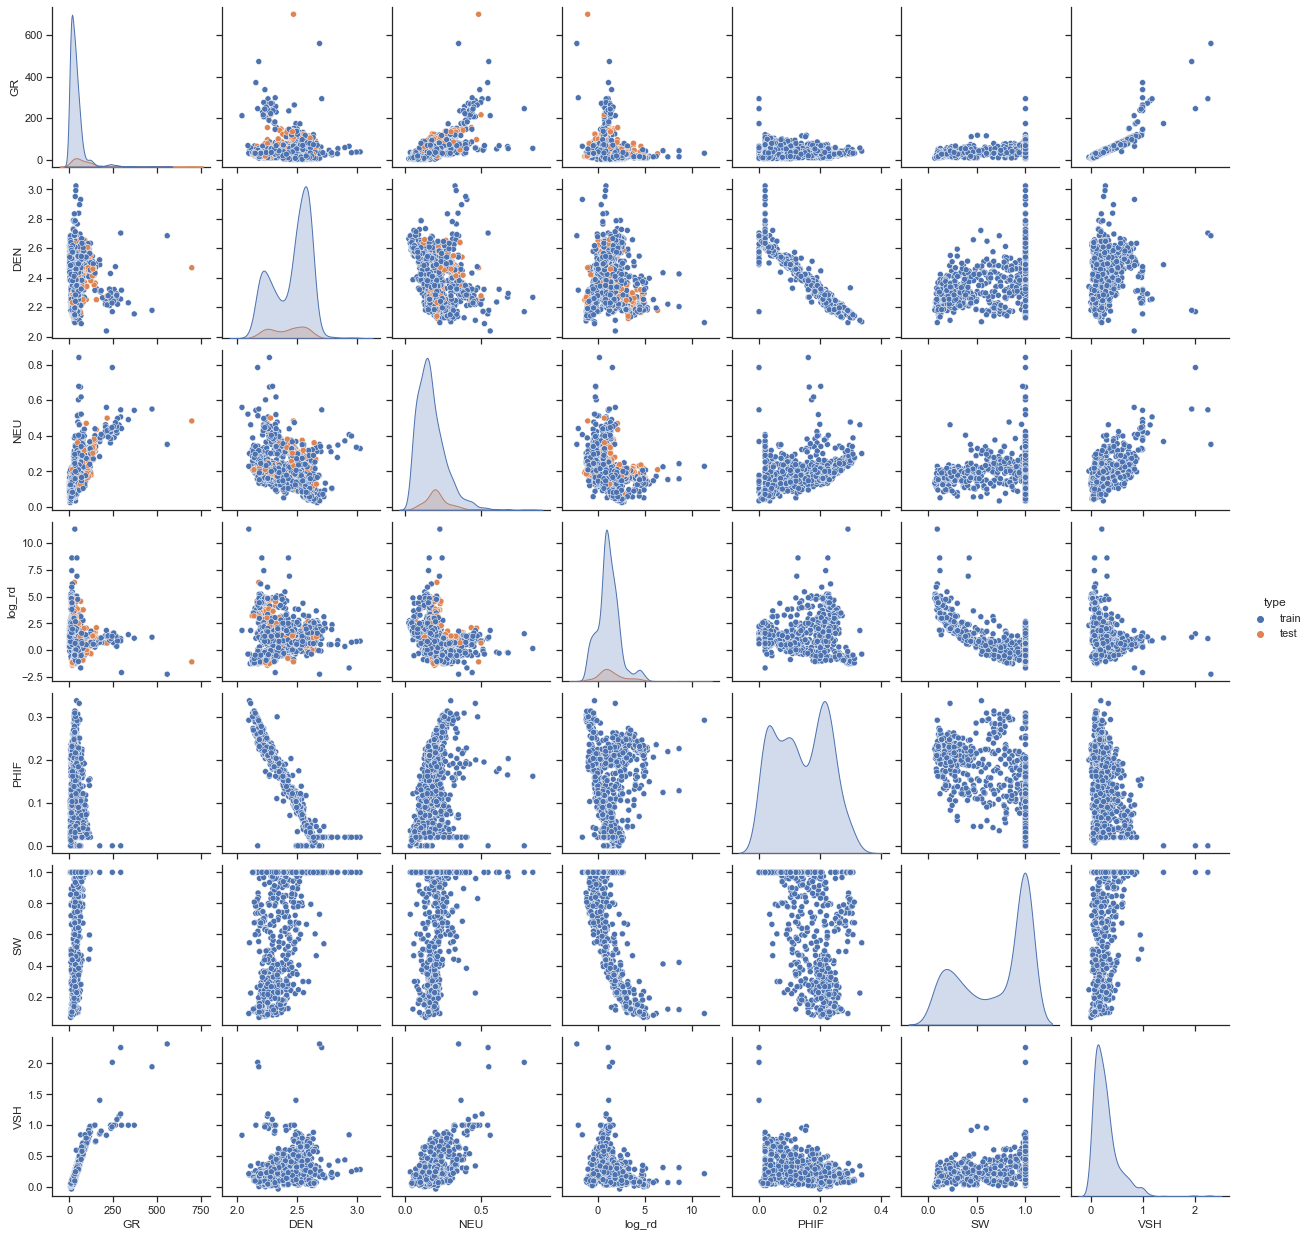

In [58]:
# From scatter plot we can find a good coverage of test data
sns.pairplot(all_dat[[ 'GR', 'DEN', 'NEU', 'log_rd', 'PHIF', 'SW', 'VSH','type']].sample(2000), hue='type')

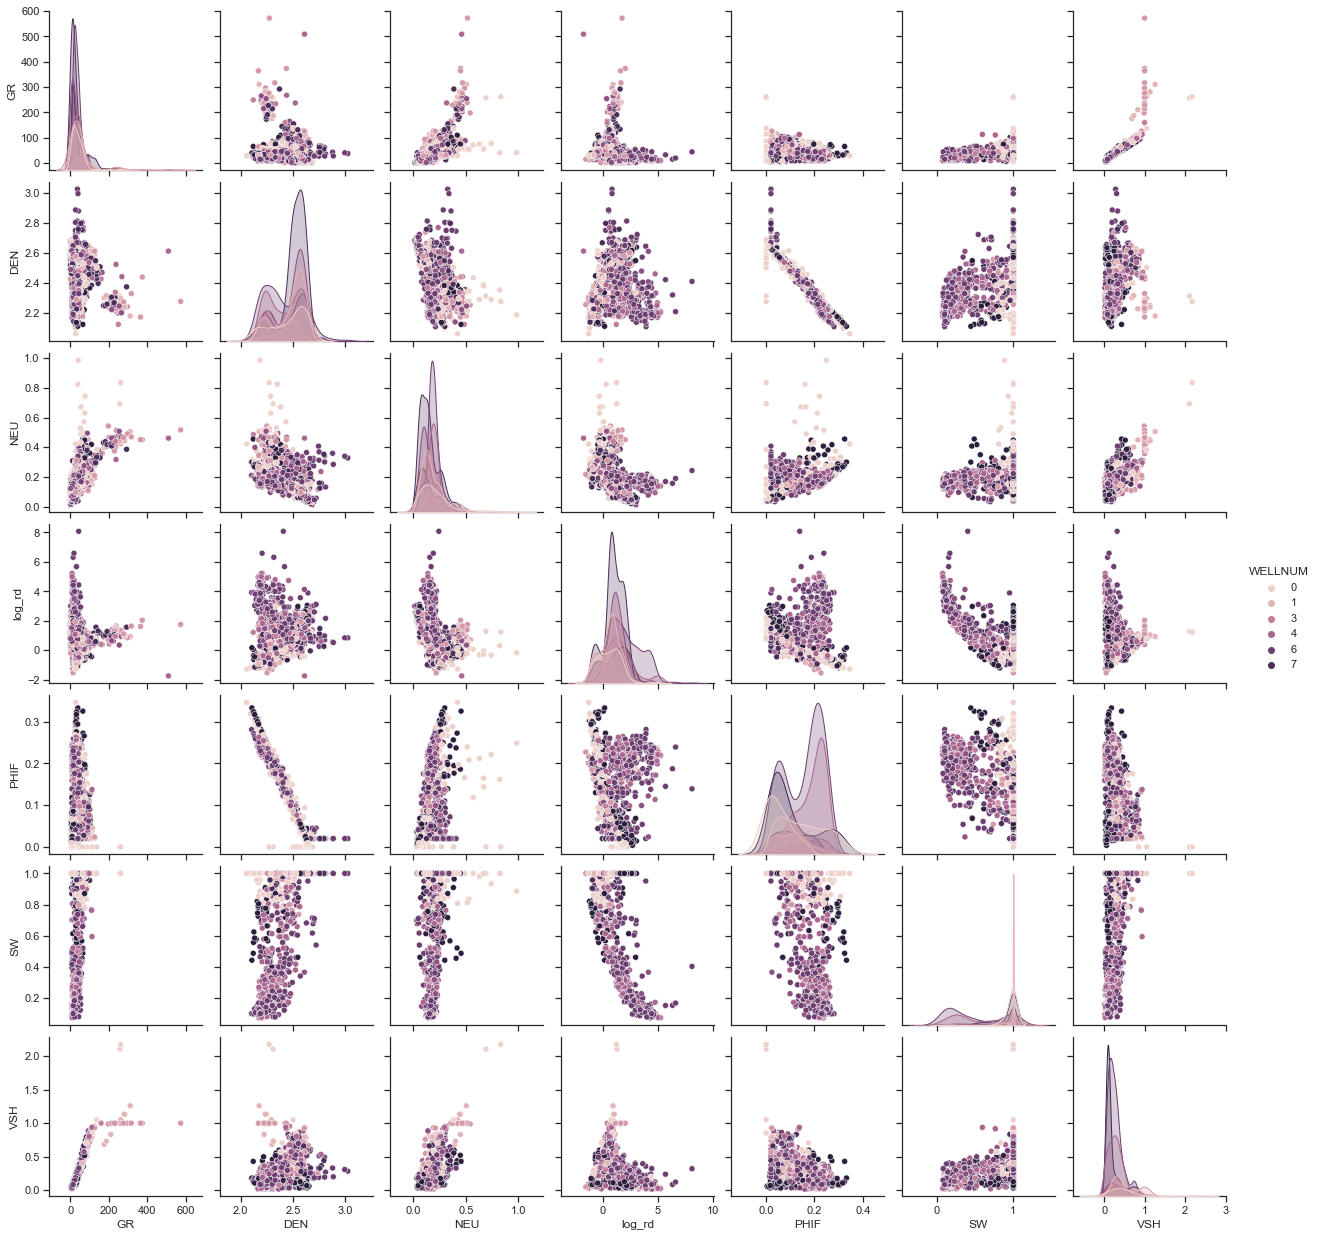

In [59]:
sns.pairplot(all_dat.loc[all_dat['type']=='train',[ 'GR', 'DEN', 'NEU', 'log_rd', 'PHIF', 'SW', 'VSH',
                                                   'WELLNUM']].sample(2000), hue='WELLNUM')
# data are not stationary, distributions vary with wells, indicating different zones or regional nonstationarity.

## Perform Zonation Based on GR, Calculate Pure Shale Non-Shale GR values

In [60]:
# calculate gr of pure shale and non-shale and perform zonation based on baselines
mylist=['GR','VSH']
for i in range(len(per_well)):
    per_well[i]['sand']=np.nan
    per_well[i]['shale']=np.nan
    # interpolate when vsh is larger than 0.95 or smaller than 0.05
    good0=per_well[i][mylist].notnull().all(1)
    good=per_well[i][mylist].notnull().all(1)*(per_well[i]['VSH']<0.95)*(per_well[i]['VSH']>0.05)
    data=per_well[i][good].copy()
    idx=np.array(data.index)
    print(i)
    for j in range(data.shape[0]-11):
        model= LinearRegression().fit(data['VSH'].values[j:j+11].reshape([-1,1]), data['GR'].values[j:j+11].reshape([-1,1]))
        data.loc[idx[j+5],'shale']=model.predict(np.array([1]).reshape(-1,1))[0][0]
        data.loc[idx[j+5],'sand']=model.predict(np.array([0]).reshape(-1,1))[0][0]
    per_well[i].loc[good,['sand','shale']]=data.loc[:,['sand','shale']].values
    if i==1: # results at this interval is not reasonable, interpolation is performed
        per_well[i].loc[60766:61017,['sand','shale']]=np.nan # get unreasonable results
    per_well[i].loc[good0,['sand','shale']]=per_well[i].loc[good0,['sand','shale']].interpolate(method='nearest', axis=0).ffill().bfill()

0
1
2
3
4
5
6
7
8


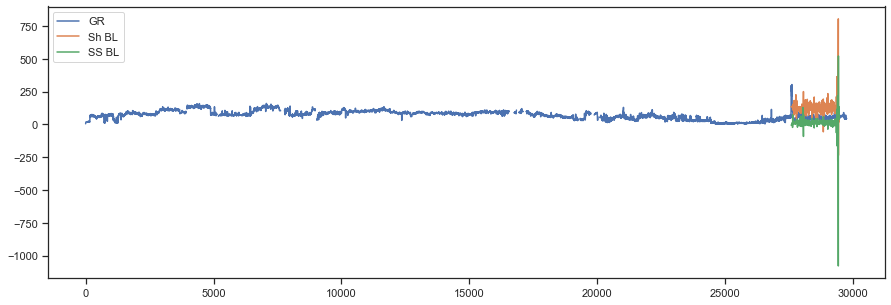

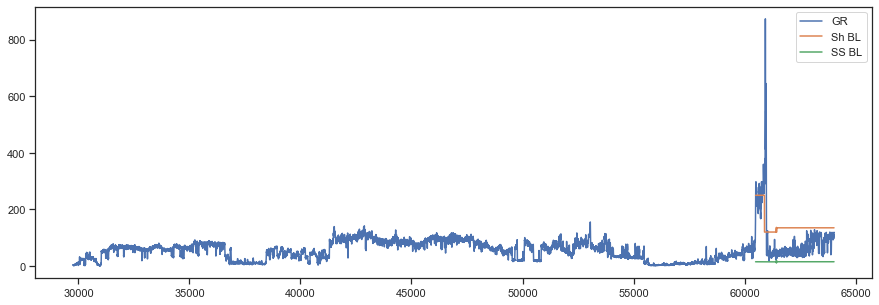

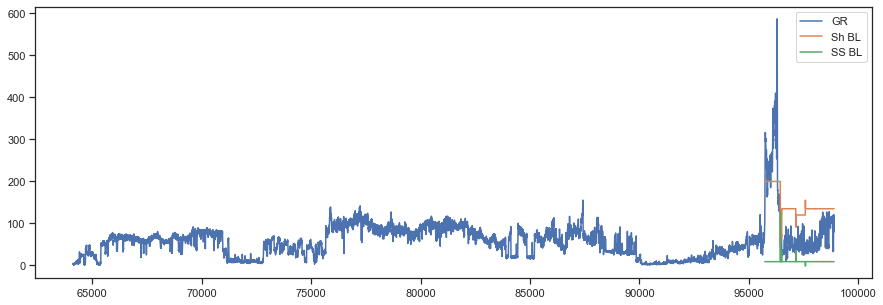

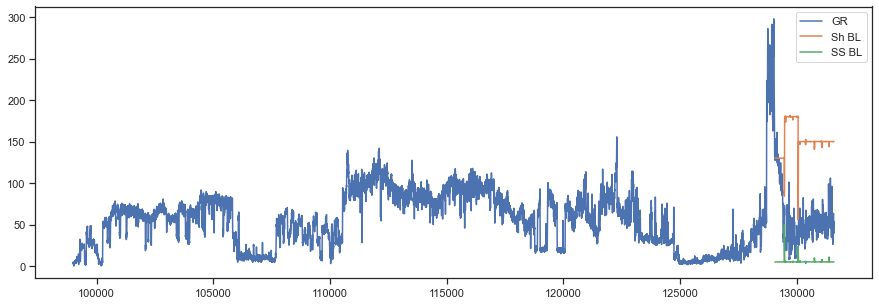

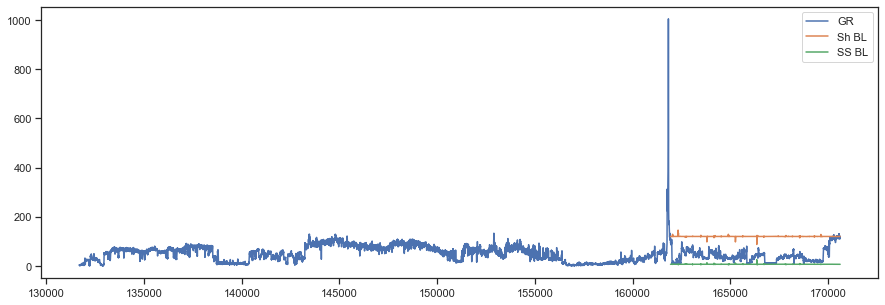

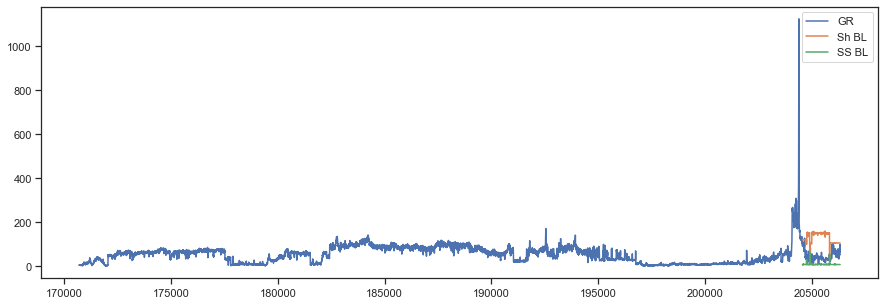

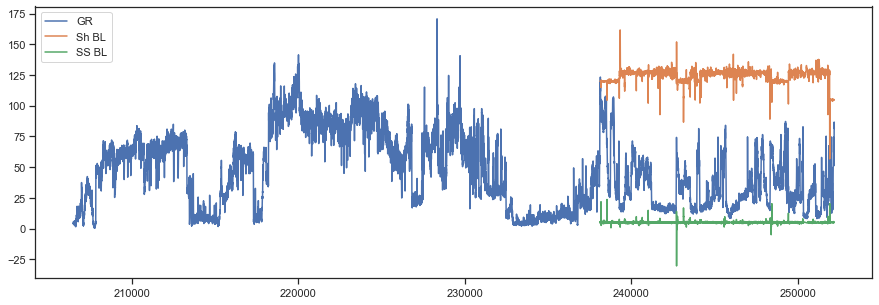

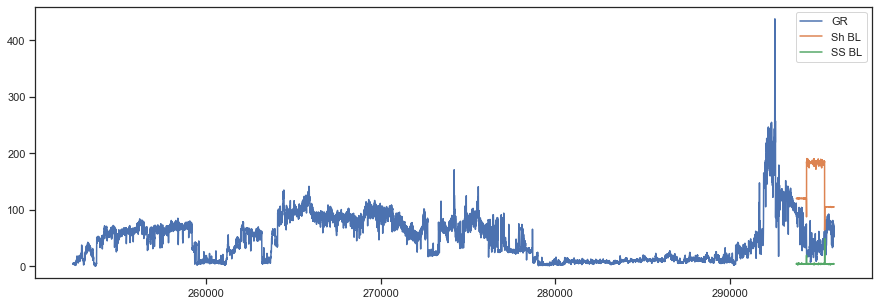

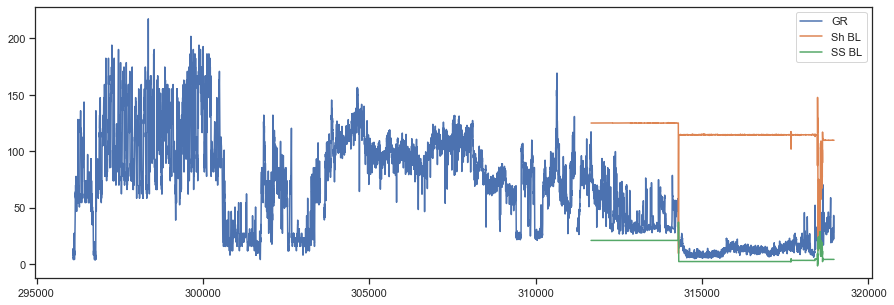

In [61]:
# Check variation of pure shale and sand
for i in range(len(per_well)):
    plt.figure(figsize=(15,5))
    plt.plot(per_well[i]['GR'],label='GR')
    plt.plot(per_well[i]['shale'],label='Sh BL')        
    plt.plot(per_well[i]['sand'],label='SS BL')  
    plt.legend()

In [62]:
# Data is noisy, mannualy decide bounaries can improve results
good=[]
for i in range(len(per_well)):
    good.append(~per_well[i][mylist].notnull().all(1))

per_well[0]['zone']=0
per_well[1]['zone']=1
per_well[1].loc[60895:61430,'zone']=2
per_well[1].loc[61430:,'zone']=3
per_well[2]['zone']=4
per_well[2].loc[96440:96500,'zone']=5
per_well[2].loc[96500:,'zone']=6
per_well[2].loc[97145:97580,'zone']=7
per_well[3]['zone']=8
per_well[3].loc[129468:130055,'zone']=9
per_well[3].loc[130055:,'zone']=10
per_well[4]['zone']=11
per_well[5]['zone']=12
per_well[5].loc[204762:205833,'zone']=13
per_well[5].loc[205833:,'zone']=14
per_well[6]['zone']=15
per_well[7]['zone']=16
per_well[7].loc[294410:295450,'zone']=17
per_well[7].loc[295450:,'zone']=18
per_well[8]['zone']=19
per_well[8].loc[314300:,'zone']=20
n_zone=21

for i in range(len(per_well)):
    per_well[i].loc[good[i],'zone']=np.nan

In [63]:
# Clean baselines
sand_zone=np.zeros(n_zone)
shale_zone=np.zeros(n_zone)
zone_size=np.zeros(n_zone)
all_train=pd.concat([per_well[i] for i in range(9)],axis=0)
for i in range(n_zone):
    sand_zone[i]=np.median(all_train.loc[all_train['zone']==i,'sand'].values)
    shale_zone[i]=np.median(all_train.loc[all_train['zone']==i,'shale'].values)
    zone_size[i]=np.sum(all_train['zone'].values==i)
    all_train.loc[all_train['zone']==i,'sand']=sand_zone[i]
    all_train.loc[all_train['zone']==i,'shale']=shale_zone[i]

per_well=[all_train[all_train['WELLNUM']==i] for i in wells]# update cleaned sand shale

### Adapt Test Well to Training Well with DTW

In [64]:
thr=200 # highest GR threshould, obtained from the training data, avoid outlier effects
# Perform DTW to decide well correlation
error=np.zeros((4,9))
for i in range(4):
    print(i)
    for j in range(9):
        x=per_well2[i]['GR'].values
        x[x>thr]=thr
        train=per_well[j].dropna(axis=0,subset=['GR']).copy()
        train.loc[train['GR']>thr,'GR']=thr
        dtw_1=dtw(x,train['GR'].values,step_pattern='asymmetric',keep_internals=False,open_end=True,open_begin=True)
        error[i,j]=dtw_1.normalizedDistance


0
1
2
3


[0, 1, 3, 0]


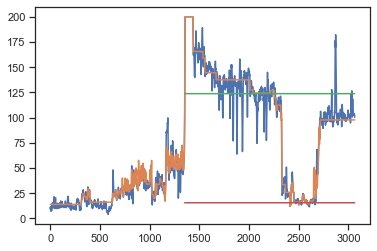

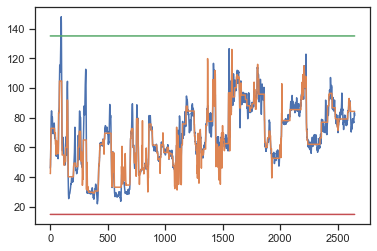

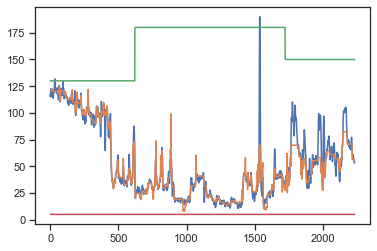

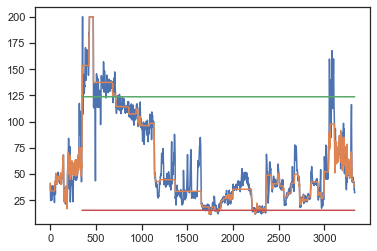

In [65]:
# DTW results
# visualize the matched interval
train_well_id=[np.argmin(error[i]) for i in np.arange(4)]
for i in range(4):
    j=train_well_id[i]
    x=per_well2[i]['GR'].values
    x[x>thr]=thr
    train=per_well[j].dropna(axis=0,subset=['GR']).copy()
    train.loc[train['GR']>thr,'GR']=thr
    dtw_1=dtw(x,train['GR'].values,step_pattern='asymmetric',keep_internals=False,open_end=True,open_begin=True)   
    plt.figure()
    plt.plot(x[dtw_1.index1s])
    plt.plot(train['GR'].values[dtw_1.index2s])
    plt.plot(train['shale'].values[dtw_1.index2s])
    plt.plot(train['sand'].values[dtw_1.index2s])
print(train_well_id)

Text(0.5, 1.0, 'Shale vs GR')

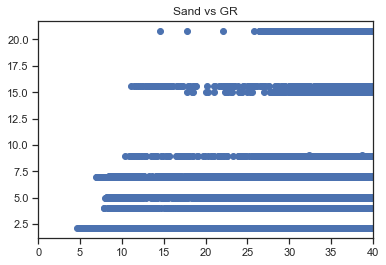

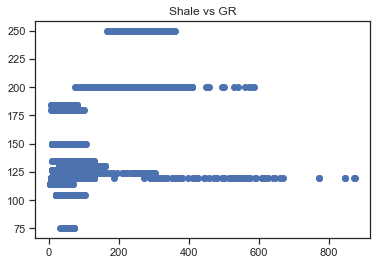

In [66]:
# Check which features are useful for baseline calculation for test wells
plt.figure()
plt.scatter(all_train['GR'],all_train['sand'])
plt.xlim(0,40)
plt.title('Sand vs GR')
plt.figure()
plt.scatter(all_train['GR'],all_train['shale'])
plt.title('Shale vs GR')
# A strong relationship between sand baseline and lower percentiles of GR is observed, 
# while the relationship to shale based line is not clear.
# We decide to use the shale base line from adapted training well and build a model between GR low percentile and sand baseline.

In [67]:
# We use type-well method described by Pan et al.(2022) to decide training data for each well
train_well_id=[np.argmin(error[i]) for i in np.arange(4)]

# sand baseline prediction with KNN and moving window, linear model is not used because of normalization
gr_sand_train=[i.dropna(axis=0,subset=['GR','VSH','sand']).copy() for i in per_well]
features=[]
sand_val=[]
window_size=1501 # moving window used to decide sand base line, this equals to half of the smallest sand zone observed in training data
percentiles=[0,5] # use 0 and 5 percentile, 0 percentile has strongest correlation, and 5 percentile is robust for sand baseline prediction
for i in gr_sand_train:
    for j in range(i.shape[0]-window_size):
        ff=np.percentile(i['GR'].values[j:j+window_size],percentiles)
        features.append(ff.copy())
        sand_val.append(i['sand'].values[j+window_size//2]-ff[0])

features=np.stack(features,axis=0)
sand_val=np.stack(sand_val,axis=0)

reg = KNeighborsRegressor().fit(features, sand_val) # We use KNN because of well log normalization issues.


sand_val=[]
for i in per_well2:
    features_test=[]
    pad_gr=np.concatenate([i['GR'].values[::-1],i['GR'].values,i['GR'].values[::-1]])
    for j in np.arange(i.shape[0]-window_size//2,2*i.shape[0]-window_size//2):
        features_test.append(np.percentile(pad_gr[j:j+window_size],percentiles))
    features_test=np.stack(features_test,axis=0)   
    sand_test=reg.predict(features_test)
    idx=np.array(i.index)
    i['sand_pred']=median_filter(sand_test.flatten()+features_test[:,0].flatten(),window_size)

# shale baseline calculation, using the shale baseline of the type well, assuming continuous shale
for i in range(len(per_well2)):
    j=train_well_id[i]
    x=per_well2[i]['GR'].values
    x[x>thr]=thr
    train=per_well[j].dropna(axis=0,subset=['GR']).copy()
    train.loc[train['GR']>thr,'GR']=thr
    dtw_1=dtw(x,train['GR'].values,step_pattern='asymmetric',keep_internals=False,open_end=True,open_begin=True)   
    shale=train['shale'].values[dtw_1.index2s]
    per_well2[i]['shale_pred']=shale[np.isfinite(shale)].mean()

In [68]:
# predict VSH
for i in range(len(per_well2)):
    per_well2[i]['vsh_pred']=(per_well2[i]['GR'].values-per_well2[i]['sand_pred'].values)/(per_well2[i]['shale_pred'].values-per_well2[i]['sand_pred'].values)
    per_well2[i].loc[per_well2[i]['vsh_pred']<0,'vsh_pred']=0
    per_well2[i].loc[per_well2[i]['vsh_pred']>1,'vsh_pred']=1    


all_test2=pd.concat(per_well2,axis=0)

## Predict  Porosity
- Since porosity estimation error is low in the validation process, we didn't spend much time and used simple linear model to perform the calculation 
- Test wells are adapted to its type well

In [69]:
all_train=pd.concat(per_well,axis=0)


for i in range(len(per_well2)):
    por_thr=0.05 # found truncations at 0.02 and 0, thus set a threshould for a better linear model training
    poro_train=per_well[train_well_id[i]].dropna(axis=0,subset=['DEN','PHIF']).copy() # a strong linear relationship exist between PHIF and DEN, for simplicity we only use DEN to predict PHIF
    x=poro_train['DEN'].values
    y=poro_train['PHIF'].values
    x=x[x>por_thr]
    y=y[x>por_thr]
    model= LinearRegression().fit(x.reshape([-1,1]),y.reshape([-1,1]))    
    
    per_well2[i]['poro_pred']=model.predict(per_well2[i]['DEN'].values.reshape(-1,1)).flatten()#yy2.copy()
    per_well2[i].loc[per_well2[i]['poro_pred']<0,'poro_pred']=0
    
all_test2=pd.concat(per_well2,axis=0)

## SW  Prediction
- Previous adaption didn't consider fluid effects, thus we use method proposed by Pan et al.(2022) to calculate new type wells

In [70]:
# Include porosity logs and resistivity logs
mykeys=['DEN','NEU','log_rd','SW']
mykeys0=['DEN','NEU','RDEP','SW']
per_well=[df1[df1['WELLNUM']==i].copy() for i in wells]   
# transform resistivity to logorithmic scale
for i in range(len(per_well)):
    per_well[i]=per_well[i].dropna(axis=0,subset=mykeys0).copy()
    per_well[i]['depth_norm']=(per_well[i]['DEPTH'].values-per_well[i]['DEPTH'].min())/(per_well[i]['DEPTH'].max()-per_well[i]['DEPTH'].min())
    per_well[i]['log_rd']=np.log(per_well[i]['RDEP'].values)
    per_well[i].dropna(axis=0, subset=mykeys, inplace=True)
for i in range(len(per_well2)):
    per_well2[i]['depth_norm']=(per_well2[i]['DEPTH'].values-per_well2[i]['DEPTH'].min())/(per_well2[i]['DEPTH'].max()-per_well2[i]['DEPTH'].min())
    per_well2[i]['log_rd']=np.log(per_well2[i]['RDEP'].values)


well_list=np.arange(9)
all_train=pd.concat([per_well[i] for i in well_list],axis=0).copy()

In [71]:
# statistical distance calculation
def KLdivergence(x, y):
  """Compute the Kullback-Leibler divergence between two multivariate samples.
  Parameters
  ----------
  x : 2D array (n,d)
    Samples from distribution P, which typically represents the true
    distribution.
  y : 2D array (m,d)
    Samples from distribution Q, which typically represents the approximate
    distribution.
  Returns
  -------
  out : float
    The estimated Kullback-Leibler divergence D(P||Q).
  References
  ----------
  Pérez-Cruz, F. Kullback-Leibler divergence estimation of
continuous distributions IEEE International Symposium on Information
Theory, 2008.
  """


  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)


  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))    


In [72]:
# calculate type well based on KL div

all_well=per_well+per_well2
list1=['DEN','NEU','log_rd']
all_well=[i.dropna(axis=0, subset=list1) for i in all_well]

thr=np.inf # no thr for GR, GR is not used

div_dist=np.zeros([len(all_well),len(all_well)])

scaler = StandardScaler()
scaler.fit(median_filter(all_train[list1].values,size=(7,1),mode='nearest')) # remove outliers and noises


for ii in range(len(all_well)):
    m=all_well[ii][list1].values[all_well[ii]['GR'].values<thr]
    m=median_filter(m,size=(7,1),mode='nearest') # remove outlier
    x=scaler.transform(m)

    for i in range(len(all_well)):
        if i<ii and ii>0:
            m2=all_well[i][list1].values[all_well[i]['GR'].values<thr]
            m2=median_filter(m2,size=(7,1),mode='nearest')
            y=scaler.transform(m2)#.reshape([-1,1])
            x=x+0.0000001*np.random.normal(0,1,x.shape) # well logs are rounded off,small values do not change the result
            y=y+0.0000001*np.random.normal(0,1,y.shape)
            div_dist[ii,i]=KLdivergence(x,y)+KLdivergence(y,x)
            
for ii in range(len(all_well)):
    for i in range(len(all_well)):
        if i>ii:
            div_dist[ii,i]=div_dist[i,ii]


train_well_id=[np.argsort(div_dist[i+9,:9])[0] for i in np.arange(4)]

In [73]:

well_list=np.arange(9)
for i in range(4):
    well_list=[train_well_id[i]]
    all_train=pd.concat([per_well[i] for i in well_list],axis=0)
    
    # simple model
    clf=KNeighborsRegressor(n_neighbors=50)

    x_dat=scaler.transform(all_train[list1].values)
    
    y_dat=all_train['SW'].values
    
    clf.fit(x_dat,y_dat)
    
    x_dat2=scaler.transform(per_well2[i][list1].values)
    y_pred_dat=clf.predict(x_dat2)

    per_well2[i]['Sw2']=y_pred_dat
    per_well2[i].loc[per_well2[i]['Sw2']>1,'Sw2']=1
    per_well2[i].loc[per_well2[i]['Sw2']<0,'Sw2']=0

all_test2=pd.concat(per_well2,axis=0)

- Apply semi-supervised learning to correct imputed data, and incorporate spatial continuity with truncation

In [74]:
# missing data are in a continuous interval of well 1
# Use accurate predictions in the same well to calculate SW at imputed points in well 1
# spatial continuity of saturation can be used to constrain the prediction
# correct imputed interval predicton with semisupervised learning and local data
df22 = pd.read_csv('test.csv')
df22.replace(['-9999', -9999], np.nan, inplace=True)
wells2=df22['WELLNUM'].unique()
per_well22=[df22[df22['WELLNUM']==i] for i in wells2]  
locs=np.where(np.isnan(df22['RDEP']))[0]
locs2=np.where(np.isfinite(per_well22[1]['RDEP']))[0]

# choose nearby intervals for training
# gr and neu are available
scaler = StandardScaler()
x_train=scaler.fit_transform(per_well22[1].loc[np.array(per_well2[1].index)[locs2[:800]],['GR','NEU']]) # use spatially close results
x_test=scaler.transform(per_well22[1].loc[locs,['GR','NEU']])
y_train=per_well2[1].loc[np.array(per_well2[1].index)[locs2[:800]],'Sw2']
clf=KNeighborsRegressor(n_neighbors=100)
clf.fit(x_train,y_train)
y_impute_pred=clf.predict(x_test)
per_well2[1].loc[locs,'Sw2']=y_impute_pred
all_test2=pd.concat(per_well2,axis=0)


In [84]:
dd=pd.read_csv('submission.csv')
dd.keys()
dd2=dd.copy()

In [85]:
dd['PHIF']=all_test2['poro_pred'].values
dd['SW']=all_test2['Sw2'].values
dd['VSH']=all_test2['vsh_pred'].values

In [86]:
print(np.sqrt(np.mean((dd.values-dd2.values)**2)))

6.270455365856386e-05


In [78]:
dd.to_csv('submission_final.csv',index=False)

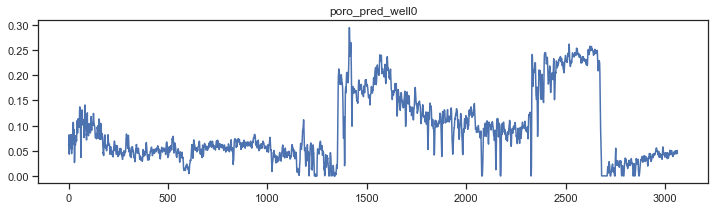

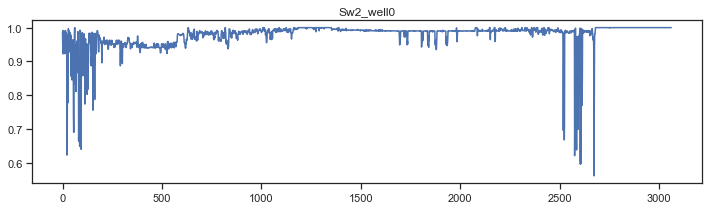

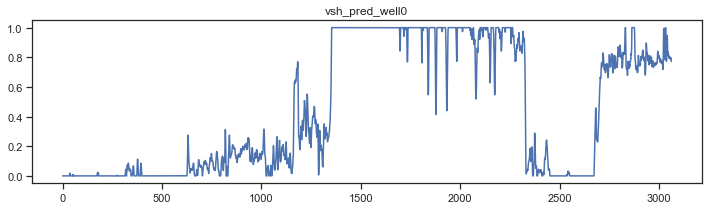

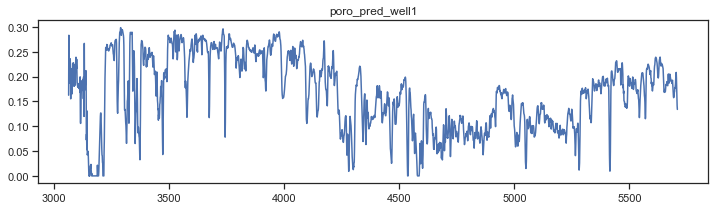

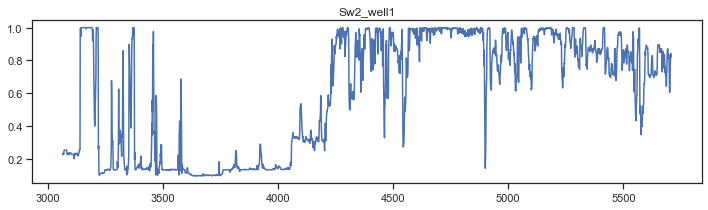

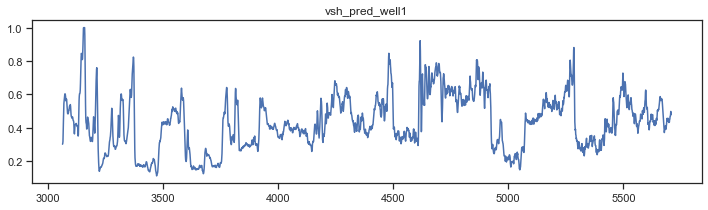

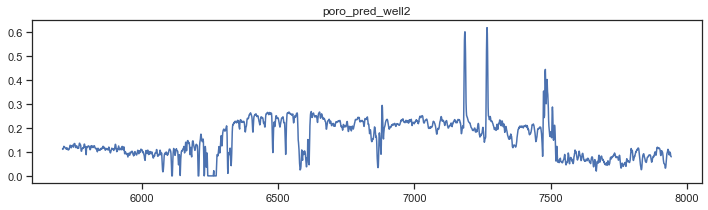

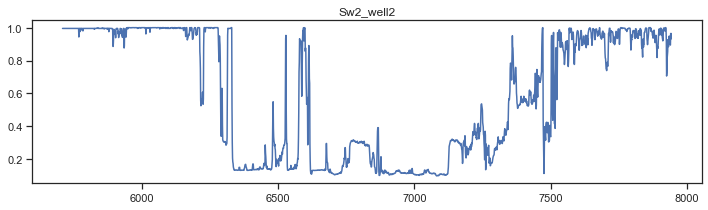

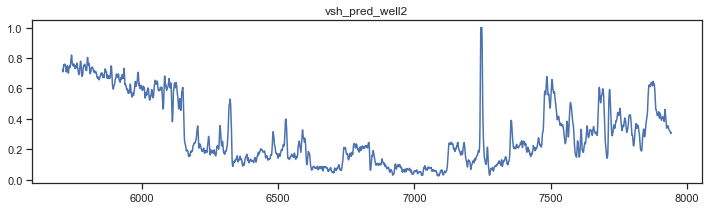

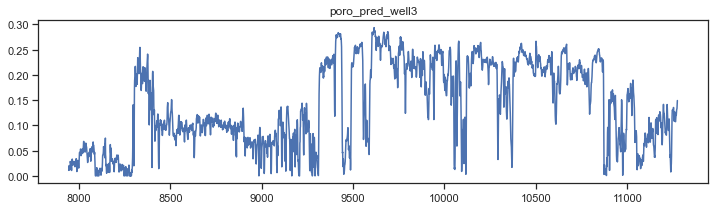

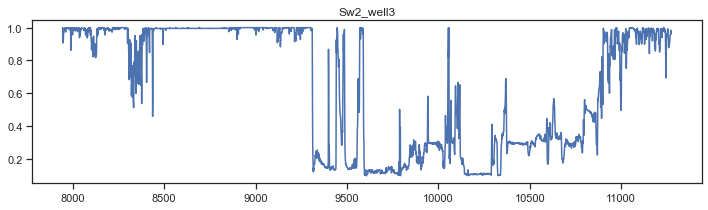

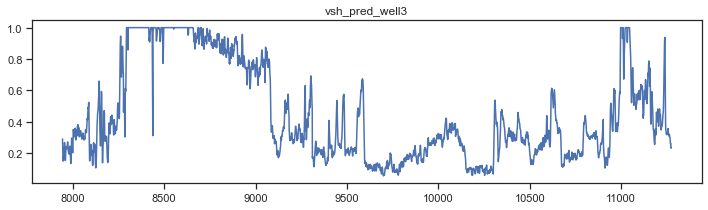

In [79]:
#Visualize results
for c,i in enumerate(per_well2):
    for j in ['poro_pred','Sw2','vsh_pred']:
        plt.figure(figsize=(12,3))
        plt.plot(i[j])
        plt.title(j+'_well'+str(c))

## <a>7. Discussion</a>

There are many things worth further exploration. We list several of them here:
1. Using other methods to find type well
2. Try multiple type wells for a test well
3. Apply more sophisticated models to make robust prediction

## References

Giorgino, T., Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.

Pan, W., Verdin, C., Duncan, I., Pyrcz, M., 2022, Reducing the Uncertainty of Multi-Well Petrophysical Interpretation from Well Logs with Statistical and Machine Learning Models, submitted

Pan, W., Verdin, C., Duncan, I., Pyrcz, M.,2021, Feature Engineering in Well-Log Interpretation, presented at GEOGULF 2021

Pan, W., Verdin, C., Duncan, I., Pyrcz, M., 2021, Well-Log Normalization and Well-to-Well Correlation via Machine Learning Methods presented at 2021 UT DIRECT and Formation Evaluation Consortium

Pérez-Cruz, F. Kullback-Leibler divergence estimation ofcontinuous distributions IEEE International Symposium on Information Theory, 2008.

J. Stat. Soft., doi:10.18637/jss.v031.i07

Yu, Y., Xu, C., Misra, S., Li, W., Ashby, M., Pan, W., Deng, T., Jo, H., Santos, J.E., Fu, L. and Wang, C., 2021, Synthetic Sonic Log Generation With Machine Learning: A Contest Summary From Five Methods, Petrophysics, 62(4), 393–406.
